In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import itertools

warnings.filterwarnings('ignore')

Loading and sampling main HMDA data...
Processed chunk, current sample size: 3500
Processed chunk, current sample size: 7000
Processed chunk, current sample size: 10500
Processed chunk, current sample size: 14000
Processed chunk, current sample size: 17500
Processed chunk, current sample size: 21000
Processed chunk, current sample size: 24500
Processed chunk, current sample size: 28000
Processed chunk, current sample size: 31500
Processed chunk, current sample size: 35000
Processed chunk, current sample size: 38500
Processed chunk, current sample size: 42000
Processed chunk, current sample size: 45500
Processed chunk, current sample size: 49000
Processed chunk, current sample size: 52500
Processed chunk, current sample size: 56000
Processed chunk, current sample size: 59500
Processed chunk, current sample size: 63000
Processed chunk, current sample size: 66500
Processed chunk, current sample size: 70000
Processed chunk, current sample size: 73500
Processed chunk, current sample size: 7

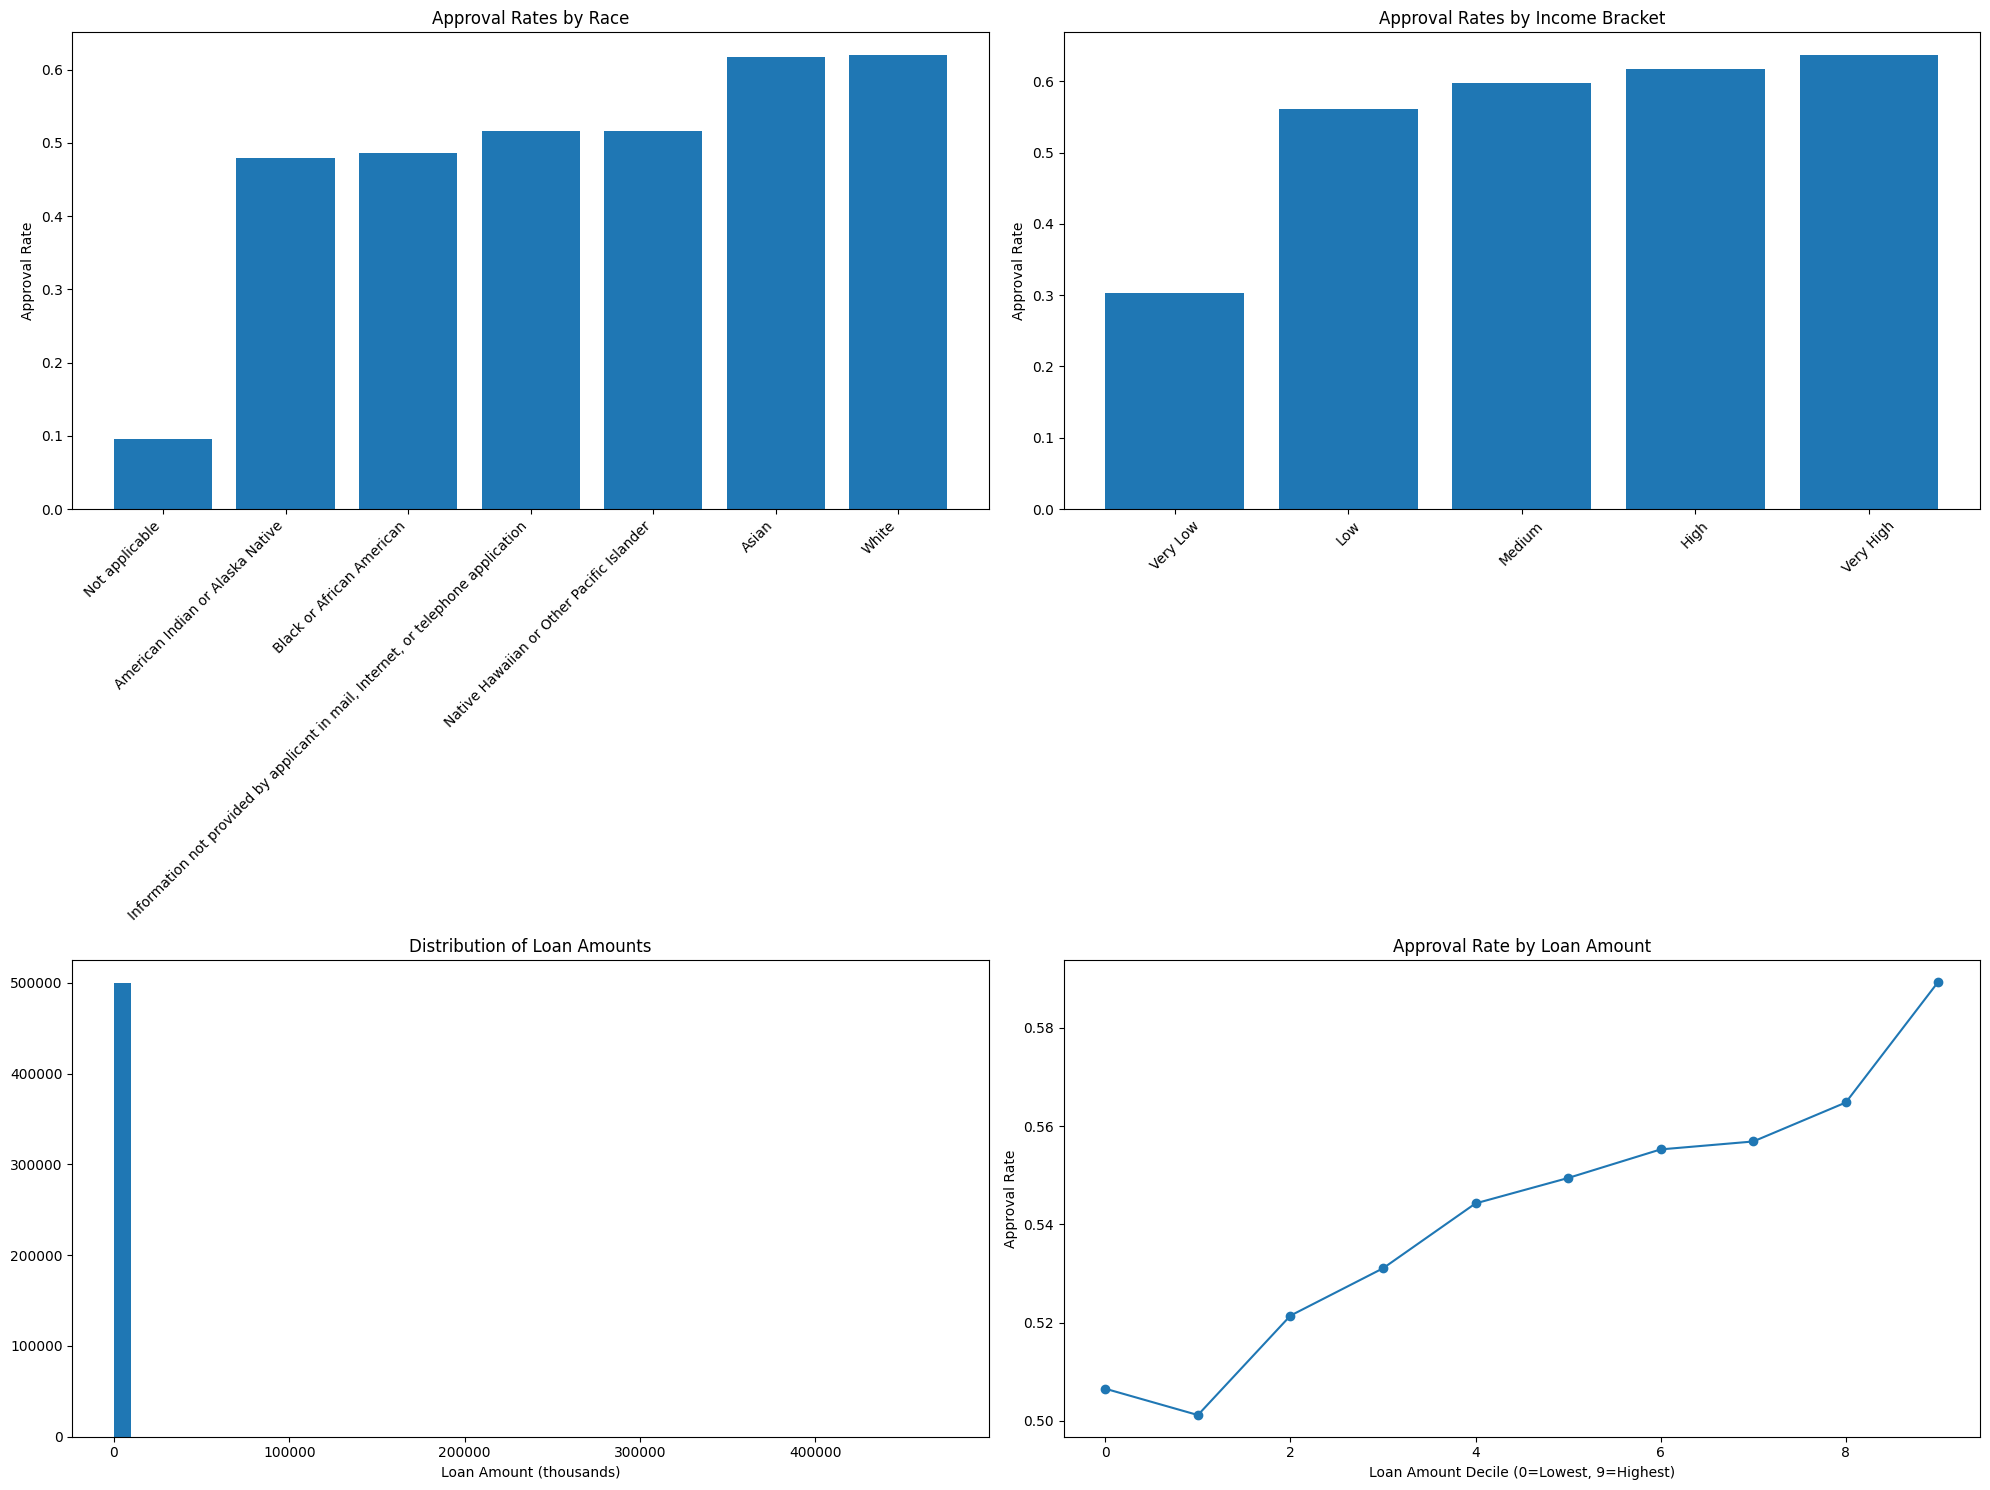

In [3]:
# part 1

def load_and_prepare_data(main_file: str, panel_file: str, ts_file: str, sample_size: int = 500000) -> Tuple[pd.DataFrame, Dict]:
    """
    Load and prepare the HMDA dataset using chunked processing and sampling.
    Returns processed dataframe and data statistics dictionary.
    """
    # Define only the columns we need
    needed_columns = [
        'action_taken',
        'loan_amount_000s',
        'applicant_income_000s',
        'applicant_race_name_1',
        'applicant_ethnicity',
        'applicant_sex',
        'hud_median_family_income',
        'denial_reason_1',
        'state_code',
        'county_code',
        'minority_population',
        'tract_to_msamd_income'
    ]
    
    print("Loading and sampling main HMDA data...")
    
    # Initialize empty list to store chunks
    chunks = []
    chunk_size = 100000  # Adjust this based on your available memory
    
    # Read the file in chunks
    for chunk in pd.read_csv(main_file, 
                           usecols=needed_columns,
                           chunksize=chunk_size):
        # Sample from each chunk proportionally
        chunk_sample_size = int(sample_size * (chunk_size / 14285496))  # Total records from your output
        sampled_chunk = chunk.sample(n=min(chunk_sample_size, len(chunk)))
        chunks.append(sampled_chunk)
        
        # Print progress
        print(f"Processed chunk, current sample size: {sum(len(chunk) for chunk in chunks)}")
        
        if sum(len(chunk) for chunk in chunks) >= sample_size:
            break
    
    # Combine chunks
    df = pd.concat(chunks, ignore_index=True)
    print(f"Final sample size: {len(df)}")
    
    # Basic data cleaning
    print("Performing initial data cleaning...")
    
    # Convert action_taken to binary (approved = 1, denied = 0)
    df['approved'] = df['action_taken'].isin([1, 2]).astype(int)
    
    # Calculate approval rates by different demographics
    stats = {}
    
    # Overall approval rate
    stats['overall_approval_rate'] = df['approved'].mean()
    
    # Approval rates by race (using primary race)
    race_approvals = df.groupby('applicant_race_name_1')['approved'].agg(['mean', 'count'])
    stats['race_approval_rates'] = race_approvals
    
    # Approval rates by income bracket
    df['income_bracket'] = pd.qcut(df['applicant_income_000s'].fillna(-1), 
                                 q=5, 
                                 labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    income_approvals = df.groupby('income_bracket')['approved'].agg(['mean', 'count'])
    stats['income_approval_rates'] = income_approvals
    
    # Calculate loan amount approval rates
    # Create loan amount bins
    df['loan_bin'] = pd.qcut(df['loan_amount_000s'].dropna(), q=10, labels=False)
    loan_approval_rates = df.groupby('loan_bin')['approved'].mean()
    stats['loan_amount_approval_rates'] = loan_approval_rates.tolist()
    
    print("\nBasic dataset statistics:")
    print(f"Number of applications: {len(df):,}")
    print(f"Number of approved loans: {df['approved'].sum():,}")
    print(f"Overall approval rate: {df['approved'].mean():.2%}")
    
    return df, stats

def generate_exploratory_plots(df: pd.DataFrame, stats: Dict) -> None:
    """
    Generate exploratory plots to visualize key patterns in the data.
    """
    plt.figure(figsize=(20, 15))
    
    # 1. Approval Rates by Race
    plt.subplot(2, 2, 1)
    approval_by_race = stats['race_approval_rates']['mean'].sort_values()
    plt.bar(range(len(approval_by_race)), approval_by_race.values)
    plt.title('Approval Rates by Race')
    plt.xticks(range(len(approval_by_race)), 
              approval_by_race.index, 
              rotation=45, 
              ha='right')
    plt.ylabel('Approval Rate')
    
    # 2. Approval Rates by Income Bracket
    plt.subplot(2, 2, 2)
    income_approval = stats['income_approval_rates']['mean']
    plt.bar(range(len(income_approval)), income_approval.values)
    plt.title('Approval Rates by Income Bracket')
    plt.xticks(range(len(income_approval)), 
               income_approval.index,
               rotation=45)
    plt.ylabel('Approval Rate')
    
    # 3. Distribution of Loan Amounts
    plt.subplot(2, 2, 3)
    plt.hist(df['loan_amount_000s'].dropna(), bins=50)
    plt.title('Distribution of Loan Amounts')
    plt.xlabel('Loan Amount (thousands)')
    
    # 4. Approval Rate by Loan Amount
    plt.subplot(2, 2, 4)
    plt.plot(range(10), stats['loan_amount_approval_rates'], marker='o')
    plt.title('Approval Rate by Loan Amount')
    plt.xlabel('Loan Amount Decile (0=Lowest, 9=Highest)')
    plt.ylabel('Approval Rate')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # File paths
    main_file = 'HDMA/hmda_2017_nationwide_all-records_labels.csv'
    panel_file = 'HDMA/hmda_2017_panel.csv'
    ts_file = 'HDMA/hmda_2017_transmittal_sheet.csv'
    
    # Load and prepare data
    df, stats = load_and_prepare_data(main_file, panel_file, ts_file)
    
    # Generate exploratory visualizations
    generate_exploratory_plots(df, stats)

In [4]:
# part 2

def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict[str, List[str]]]:
    """
    Preprocess the HMDA dataset and create feature groups for analysis.
    Returns preprocessed dataframe and dictionary of feature groups.
    """
    print("Starting data preprocessing...")
    
    # Create copy to avoid modifying original data
    data = df.copy()
    
    # Remove rows where action_taken is not 1, 2, or 3 
    # (these are withdrawn/incomplete applications)
    data = data[data['action_taken'].isin([1, 2, 3])]
    
    # Define feature groups based on available columns
    feature_groups = {
        'baseline': [
            'loan_amount_000s',
            'applicant_income_000s',
            'hud_median_family_income',
            'tract_to_msamd_income',
            'income_to_loan_ratio',  # Will be created
            'area_income_ratio'      # Will be created
        ],
        
        'location': [
            'state_code',
            'county_code',
            'minority_population'
        ],
        
        'sensitive': [
            'applicant_race_name_1',
            'applicant_ethnicity',
            'applicant_sex'
        ]
    }
    
    # Handle missing values
    print("Handling missing values...")
    
    # Numeric columns: fill with median
    numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        data[col] = data[col].fillna(data[col].median())
    
    # Categorical columns: fill with mode
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        data[col] = data[col].fillna(data[col].mode()[0])
    
    # Create derived features
    print("Creating derived features...")
    
    # Income to loan ratio
    data['income_to_loan_ratio'] = (data['applicant_income_000s'] / 
                                   data['loan_amount_000s']).replace([np.inf, -np.inf], np.nan)
    data['income_to_loan_ratio'] = data['income_to_loan_ratio'].fillna(
        data['income_to_loan_ratio'].median())
    
    # Area income ratio
    data['area_income_ratio'] = (data['applicant_income_000s'] / 
                                data['hud_median_family_income']).replace([np.inf, -np.inf], np.nan)
    data['area_income_ratio'] = data['area_income_ratio'].fillna(
        data['area_income_ratio'].median())
    
    return data, feature_groups

def create_model_datasets(data: pd.DataFrame, 
                        feature_groups: Dict[str, List[str]], 
                        test_size: float = 0.2,
                        random_state: int = 42) -> Dict[str, Tuple]:
    """
    Create different datasets for model training with different feature combinations.
    Returns dictionary with various train-test splits.
    """
    print("Creating model datasets...")
    
    datasets = {}
    
    # Create label encoder for categorical variables
    le = LabelEncoder()
    
    # 1. Baseline dataset (no sensitive features)
    X_baseline = data[feature_groups['baseline']].copy()
    
    # Handle categorical variables in baseline features
    categorical_baseline = X_baseline.select_dtypes(include=['object']).columns
    for col in categorical_baseline:
        X_baseline[col] = le.fit_transform(X_baseline[col])
    
    # Create target variable
    y = data['approved']
    
    # Create train-test split for baseline
    X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(
        X_baseline, y, test_size=test_size, random_state=random_state
    )
    datasets['baseline'] = (X_train_base, X_test_base, y_train_base, y_test_base)
    
    # 2. Dataset with location features
    X_with_location = pd.concat([
        X_baseline,
        data[feature_groups['location']]
    ], axis=1)
    
    categorical_loc = X_with_location.select_dtypes(include=['object']).columns
    for col in categorical_loc:
        X_with_location[col] = le.fit_transform(X_with_location[col])
    
    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(
        X_with_location, y, test_size=test_size, random_state=random_state
    )
    datasets['with_location'] = (X_train_loc, X_test_loc, y_train_loc, y_test_loc)
    
    # 3. Dataset with all features including sensitive ones
    X_all = pd.concat([
        X_baseline,
        data[feature_groups['location']],
        data[feature_groups['sensitive']]
    ], axis=1)
    
    categorical_all = X_all.select_dtypes(include=['object']).columns
    for col in categorical_all:
        X_all[col] = le.fit_transform(X_all[col])
    
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X_all, y, test_size=test_size, random_state=random_state
    )
    datasets['all_features'] = (X_train_all, X_test_all, y_train_all, y_test_all)
    
    print("\nCreated datasets with shapes:")
    for name, (X_train, X_test, y_train, y_test) in datasets.items():
        print(f"{name}:")
        print(f"  Training: {X_train.shape}")
        print(f"  Testing:  {X_test.shape}")
    
    return datasets

def prepare_scalers(datasets: Dict[str, Tuple]) -> Dict[str, StandardScaler]:
    """
    Create and fit scalers for each dataset.
    Returns dictionary of fitted scalers.
    """
    print("\nPreparing scalers...")
    
    scalers = {}
    for name, (X_train, _, _, _) in datasets.items():
        scaler = StandardScaler()
        scaler.fit(X_train)
        scalers[name] = scaler
    
    return scalers

if __name__ == "__main__":
    # Using df from Part 1
    # Preprocess data
    data, feature_groups = preprocess_data(df)
    
    # Create datasets for different model variations
    datasets = create_model_datasets(data, feature_groups)
    
    # Prepare scalers
    scalers = prepare_scalers(datasets)
    
    # Print feature group information
    print("\nFeature groups:")
    for group, features in feature_groups.items():
        print(f"\n{group} features:")
        for feature in features:
            print(f"  - {feature}")

Starting data preprocessing...
Handling missing values...
Creating derived features...
Creating model datasets...

Created datasets with shapes:
baseline:
  Training: (273197, 6)
  Testing:  (68300, 6)
with_location:
  Training: (273197, 9)
  Testing:  (68300, 9)
all_features:
  Training: (273197, 12)
  Testing:  (68300, 12)

Preparing scalers...

Feature groups:

baseline features:
  - loan_amount_000s
  - applicant_income_000s
  - hud_median_family_income
  - tract_to_msamd_income
  - income_to_loan_ratio
  - area_income_ratio

location features:
  - state_code
  - county_code
  - minority_population

sensitive features:
  - applicant_race_name_1
  - applicant_ethnicity
  - applicant_sex


Training models...
Training Random Forest on baseline dataset...
Training Logistic Regression on baseline dataset...
Training XGBoost on baseline dataset...
Training Random Forest on with_location dataset...
Training Logistic Regression on with_location dataset...
Training XGBoost on with_location dataset...
Training Random Forest on all_features dataset...
Training Logistic Regression on all_features dataset...
Training XGBoost on all_features dataset...

Evaluating model performance...

Model Evaluation Results:
         Dataset          Model  Accuracy  Precision    Recall        F1  \
0       baseline  random_forest  0.796984   0.818363  0.957665  0.882551   
1       baseline       logistic  0.797555   0.798195  0.998199  0.887063   
2       baseline        xgboost  0.807775   0.816316  0.978934  0.890260   
3  with_location  random_forest  0.803968   0.819286  0.967224  0.887130   
4  with_location       logistic  0.797643   0.798379  0.997960  0.887082   
5  with_location        

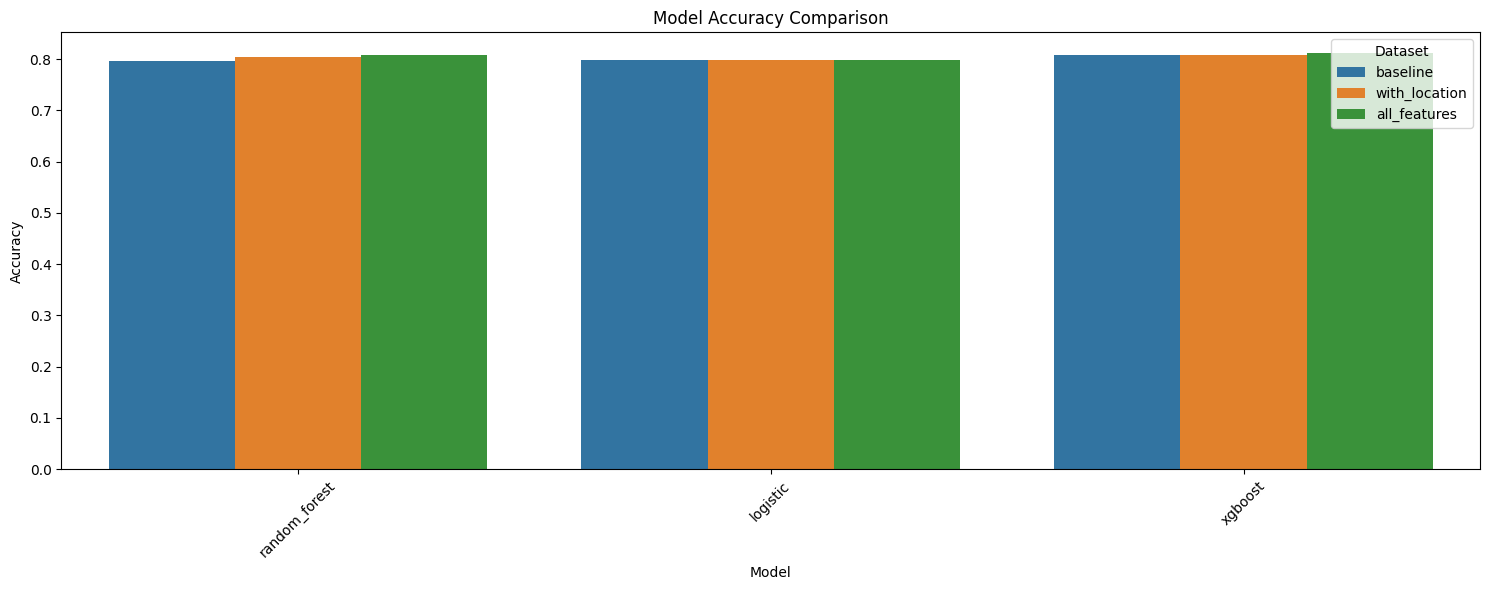

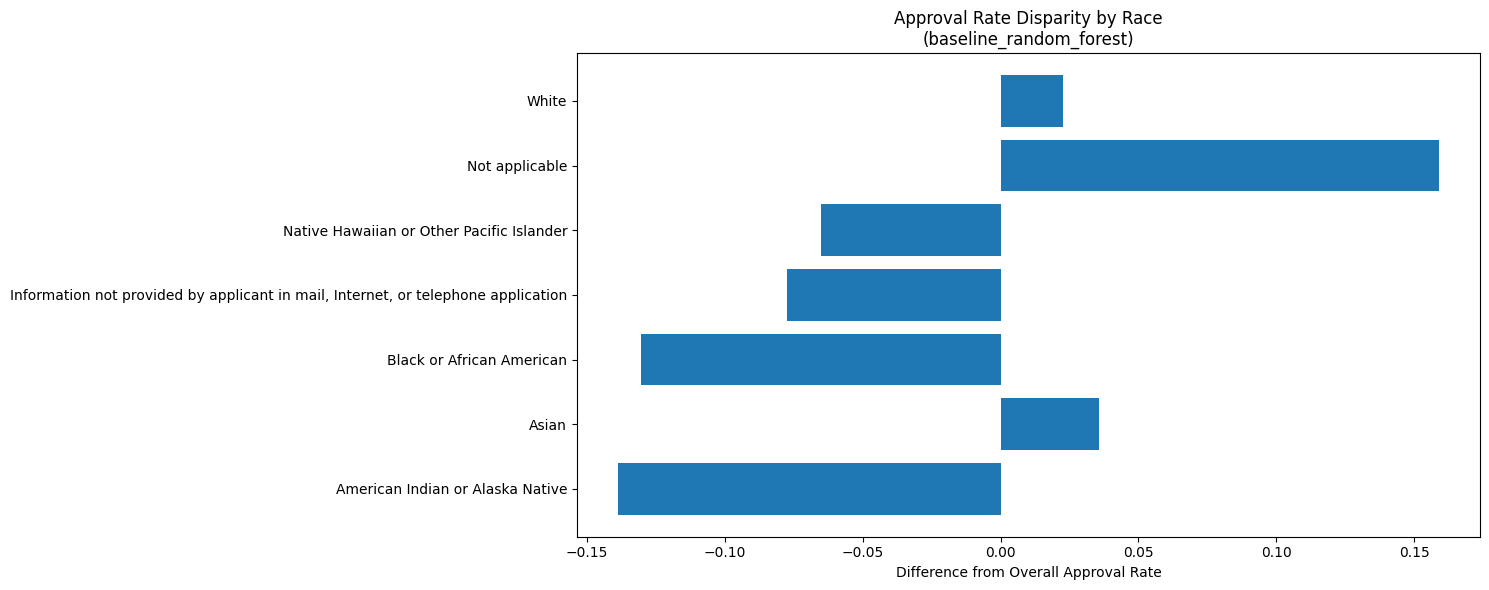


Analyzing feature importance...


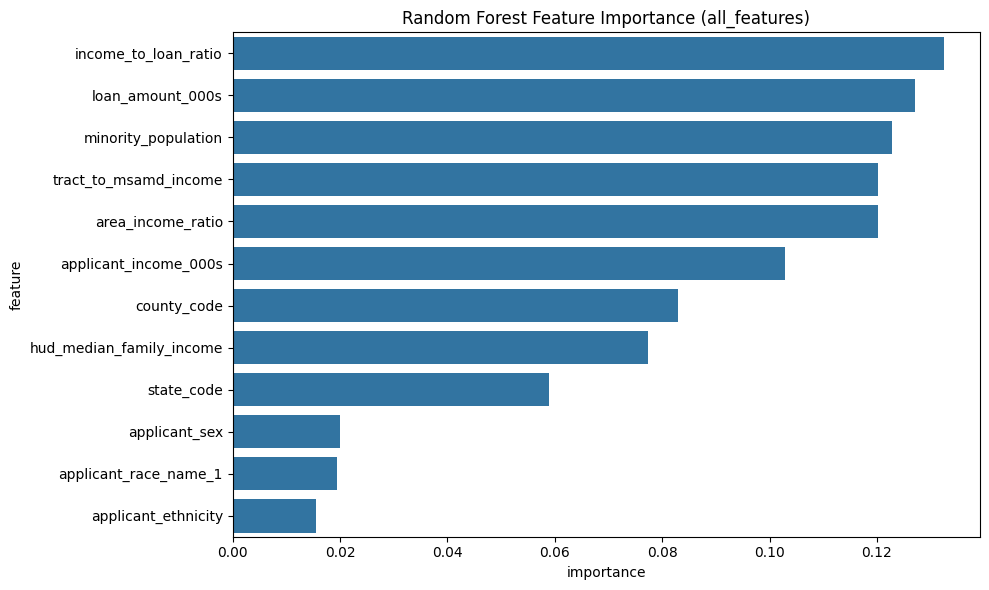

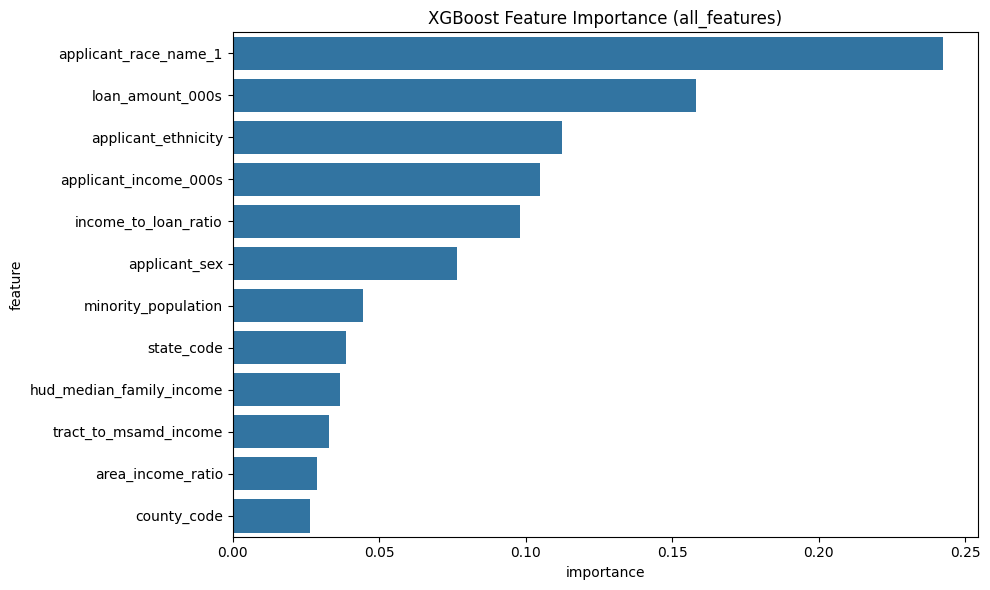


Detailed Bias Analysis:

Model: baseline_random_forest

Racial Bias Analysis:
                               applicant_race_name_1  approved  disparity
0                   American Indian or Alaska Native  0.655184  -0.138594
1                                              Asian  0.829486   0.035708
2                          Black or African American  0.663676  -0.130103
3  Information not provided by applicant in mail,...  0.716295  -0.077484
4          Native Hawaiian or Other Pacific Islander  0.728650  -0.065128
5                                     Not applicable  0.952649   0.158871
6                                              White  0.816311   0.022532

Model: baseline_logistic

Racial Bias Analysis:
                               applicant_race_name_1  approved  disparity
0                   American Indian or Alaska Native  0.655184  -0.138594
1                                              Asian  0.829486   0.035708
2                          Black or African American  0.66

In [5]:
# part 3

def train_models(datasets: Dict[str, Tuple], scalers: Dict[str, StandardScaler]) -> Dict:
    """
    Train multiple models on different feature sets and return the trained models.
    """
    print("Training models...")
    models = {}
    
    # Model configurations
    model_configs = {
        'random_forest': {
            'model': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'name': 'Random Forest'
        },
        'logistic': {
            'model': LogisticRegression(random_state=42, max_iter=1000),
            'name': 'Logistic Regression'
        },
        'xgboost': {
            'model': xgb.XGBClassifier(random_state=42, n_jobs=-1),
            'name': 'XGBoost'
        }
    }
    
    # Train models for each dataset
    for dataset_name, (X_train, X_test, y_train, y_test) in datasets.items():
        models[dataset_name] = {}
        
        # Scale the features
        X_train_scaled = scalers[dataset_name].transform(X_train)
        X_test_scaled = scalers[dataset_name].transform(X_test)
        
        # Train each model type
        for model_name, config in model_configs.items():
            print(f"Training {config['name']} on {dataset_name} dataset...")
            model = config['model']
            model.fit(X_train_scaled, y_train)
            
            # Store model and predictions
            models[dataset_name][model_name] = {
                'model': model,
                'predictions': model.predict(X_test_scaled),
                'probabilities': model.predict_proba(X_test_scaled)[:, 1],
                'feature_names': X_train.columns.tolist()
            }
    
    return models

def evaluate_models(models: Dict, datasets: Dict) -> pd.DataFrame:
    """
    Evaluate models and return performance metrics.
    """
    print("\nEvaluating model performance...")
    results = []
    
    for dataset_name, model_dict in models.items():
        _, _, _, y_test = datasets[dataset_name]
        
        for model_name, model_info in model_dict.items():
            predictions = model_info['predictions']
            probabilities = model_info['probabilities']
            
            results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Accuracy': accuracy_score(y_test, predictions),
                'Precision': precision_score(y_test, predictions),
                'Recall': recall_score(y_test, predictions),
                'F1': f1_score(y_test, predictions),
                'AUC-ROC': roc_auc_score(y_test, probabilities)
            })
    
    return pd.DataFrame(results)

def analyze_bias(models: Dict, data: pd.DataFrame, feature_groups: Dict) -> Dict:
    """
    Analyze bias in model predictions across different demographic groups.
    """
    print("\nAnalyzing model bias...")
    bias_metrics = {}
    
    # Get predictions from each model
    for dataset_name, model_dict in models.items():
        for model_name, model_info in model_dict.items():
            key = f"{dataset_name}_{model_name}"
            bias_metrics[key] = {}
            
            # Analyze approval rates by race
            race_bias = data.groupby('applicant_race_name_1').agg({
                'approved': 'mean'
            }).reset_index()
            
            # Calculate approval rate disparities
            overall_approval = data['approved'].mean()
            race_bias['disparity'] = race_bias['approved'] - overall_approval
            
            bias_metrics[key]['race_bias'] = race_bias
            
            # Add other demographic analyses as needed
            
    return bias_metrics

def plot_results(evaluation_results: pd.DataFrame, bias_metrics: Dict):
    """
    Create visualizations for model performance and bias analysis.
    """
    # Plot 1: Model Performance Comparison
    plt.figure(figsize=(15, 6))
    
    # Create grouped bar plot for accuracy
    sns.barplot(data=evaluation_results, x='Model', y='Accuracy', hue='Dataset')
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: Bias Analysis
    plt.figure(figsize=(15, 6))
    
    # Select a specific model for bias visualization
    model_key = 'baseline_random_forest'
    race_bias = bias_metrics[model_key]['race_bias']
    
    plt.barh(race_bias['applicant_race_name_1'], race_bias['disparity'])
    plt.title(f'Approval Rate Disparity by Race\n({model_key})')
    plt.xlabel('Difference from Overall Approval Rate')
    plt.tight_layout()
    plt.show()

def analyze_feature_importance(models: Dict):
    """
    Analyze and visualize feature importance for tree-based models.
    """
    print("\nAnalyzing feature importance...")
    
    for dataset_name, model_dict in models.items():
        # Handle Random Forest
        if 'random_forest' in model_dict:
            rf_info = model_dict['random_forest']
            rf_model = rf_info['model']
            rf_features = rf_info['feature_names']
            
            if len(rf_features) == len(rf_model.feature_importances_):
                feat_importance_rf = pd.DataFrame({
                    'feature': rf_features,
                    'importance': rf_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                plt.figure(figsize=(10, 6))
                sns.barplot(data=feat_importance_rf, x='importance', y='feature')
                plt.title(f'Random Forest Feature Importance ({dataset_name})')
                plt.tight_layout()
                plt.show()
        
        # Handle XGBoost
        if 'xgboost' in model_dict:
            xgb_info = model_dict['xgboost']
            xgb_model = xgb_info['model']
            xgb_features = xgb_info['feature_names']
            
            if len(xgb_features) == len(xgb_model.feature_importances_):
                feat_importance_xgb = pd.DataFrame({
                    'feature': xgb_features,
                    'importance': xgb_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                plt.figure(figsize=(10, 6))
                sns.barplot(data=feat_importance_xgb, x='importance', y='feature')
                plt.title(f'XGBoost Feature Importance ({dataset_name})')
                plt.tight_layout()
                plt.show()

if __name__ == "__main__":
    # Using data, datasets, and scalers from Part 2
    
    # Train models
    models = train_models(datasets, scalers)
    
    # Evaluate models
    evaluation_results = evaluate_models(models, datasets)
    print("\nModel Evaluation Results:")
    print(evaluation_results)
    
    # Analyze bias
    bias_metrics = analyze_bias(models, data, feature_groups)
    
    # Plot results
    plot_results(evaluation_results, bias_metrics)
    
    # Analyze feature importance
    analyze_feature_importance(models)
    
    # Print detailed bias analysis
    print("\nDetailed Bias Analysis:")
    for model_key, metrics in bias_metrics.items():
        print(f"\nModel: {model_key}")
        print("\nRacial Bias Analysis:")
        print(metrics['race_bias'])


Analyzing prediction changes between models...

Prediction Changes Analysis:
            Model                                               Race  \
0   random_forest                                              White   
1   random_forest                          Black or African American   
2   random_forest          Native Hawaiian or Other Pacific Islander   
3   random_forest  Information not provided by applicant in mail,...   
4   random_forest                                              Asian   
5   random_forest                   American Indian or Alaska Native   
6   random_forest                                     Not applicable   
7        logistic                                              White   
8        logistic                          Black or African American   
9        logistic          Native Hawaiian or Other Pacific Islander   
10       logistic  Information not provided by applicant in mail,...   
11       logistic                                         

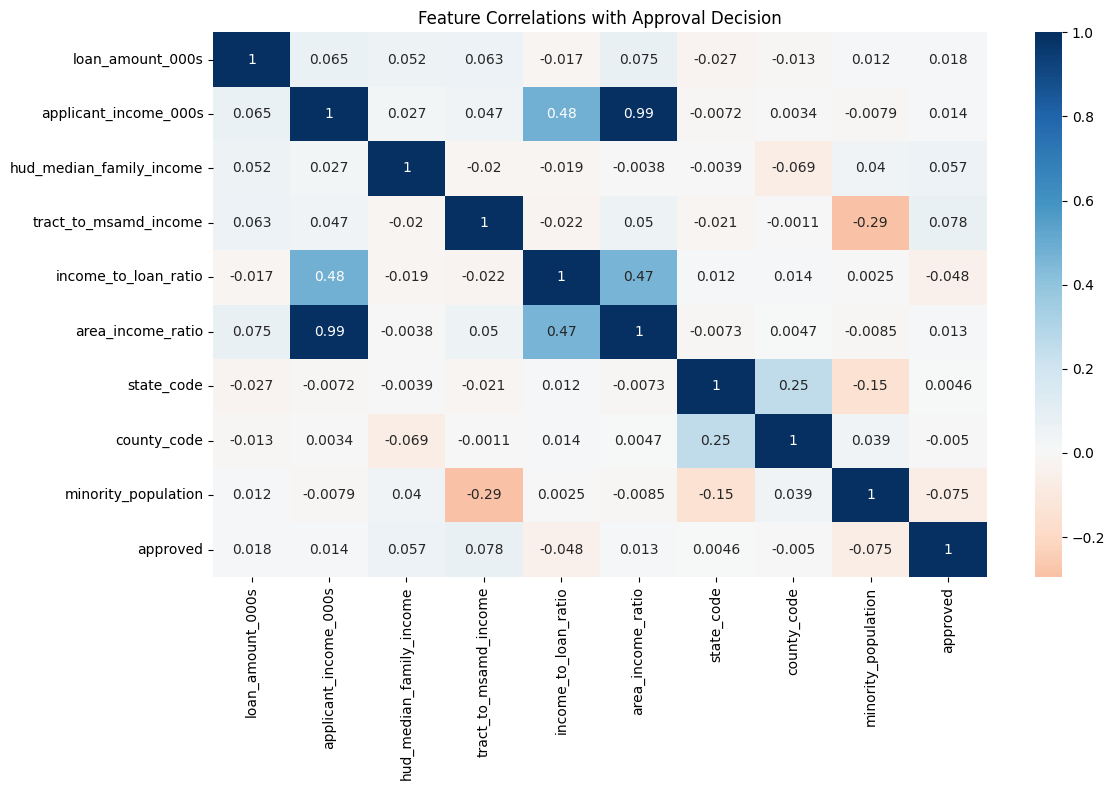

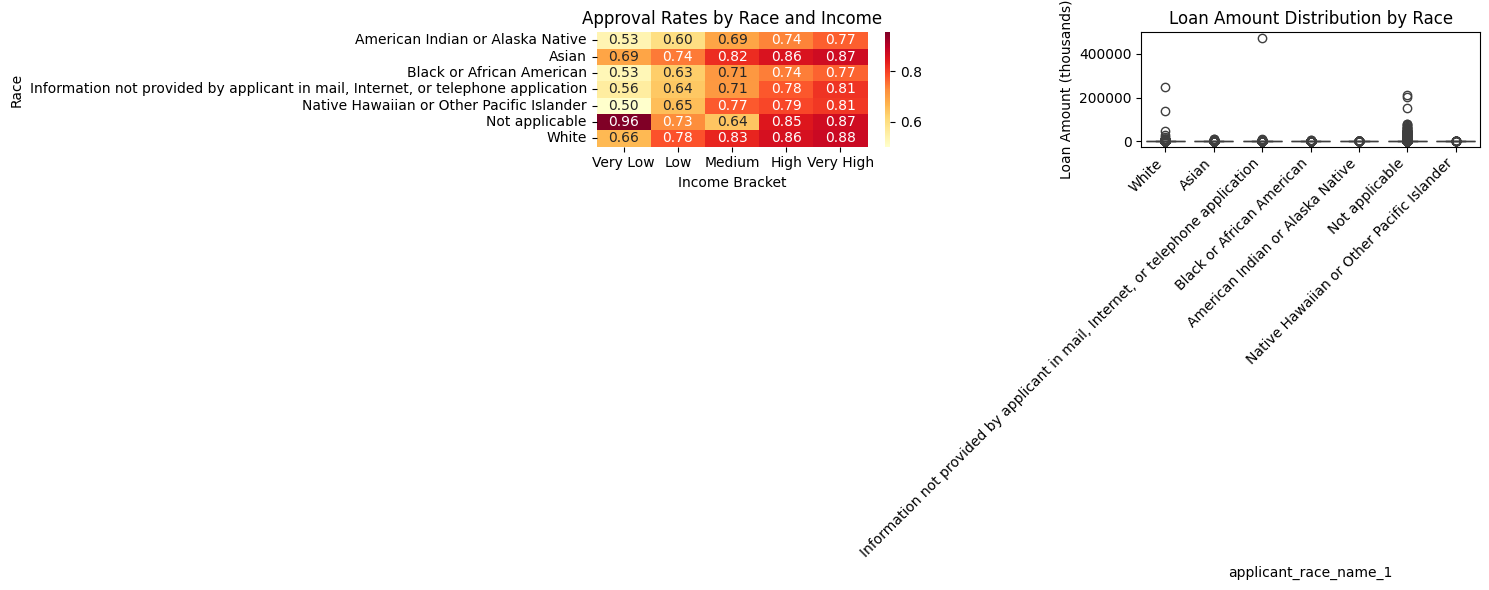

In [6]:
# part 4

def analyze_prediction_changes(models: Dict, data: pd.DataFrame, datasets: Dict) -> pd.DataFrame:
    """
    Analyze how predictions change when sensitive features are added.
    """
    print("\nAnalyzing prediction changes between models...")
    
    # Get test data indices to align predictions with demographic data
    _, test_data, _, _ = datasets['baseline']
    test_indices = test_data.index
    
    # Get the corresponding slice of demographic data
    test_demographics = data.loc[test_indices]
    
    changes = []
    
    for model_type in ['random_forest', 'logistic', 'xgboost']:
        base_preds = models['baseline'][model_type]['predictions']
        full_preds = models['all_features'][model_type]['predictions']
        
        # Find where predictions changed
        changed_predictions = (base_preds != full_preds).sum()
        
        # Analyze changes by demographic group
        for race in test_demographics['applicant_race_name_1'].unique():
            race_mask = test_demographics['applicant_race_name_1'] == race
            race_changes = (base_preds[race_mask] != full_preds[race_mask]).sum()
            
            changes.append({
                'Model': model_type,
                'Race': race,
                'Total_Changes': race_changes,
                'Change_Rate': race_changes / sum(race_mask) if sum(race_mask) > 0 else 0
            })
    
    return pd.DataFrame(changes)

def calculate_fair_metrics(models: Dict, data: pd.DataFrame, datasets: Dict) -> pd.DataFrame:
    """
    Calculate fairness metrics for each model.
    """
    print("\nCalculating fairness metrics...")
    
    # Get test data indices
    _, test_data, _, _ = datasets['baseline']
    test_indices = test_data.index
    test_demographics = data.loc[test_indices]
    
    metrics = []
    privileged_group = 'White'  # Reference group
    
    for dataset_name, model_dict in models.items():
        for model_name, model_info in model_dict.items():
            predictions = model_info['predictions']
            
            # Calculate disparate impact
            priv_mask = test_demographics['applicant_race_name_1'] == privileged_group
            priv_approval_rate = predictions[priv_mask].mean()
            
            for race in test_demographics['applicant_race_name_1'].unique():
                if race != privileged_group:
                    group_mask = test_demographics['applicant_race_name_1'] == race
                    group_approval_rate = predictions[group_mask].mean()
                    
                    if priv_approval_rate > 0:  # Avoid division by zero
                        disparate_impact = group_approval_rate / priv_approval_rate
                    else:
                        disparate_impact = np.nan
                    
                    metrics.append({
                        'Dataset': dataset_name,
                        'Model': model_name,
                        'Group': race,
                        'Approval_Rate': group_approval_rate,
                        'Disparate_Impact': disparate_impact,
                        'Equal_Opportunity_Diff': group_approval_rate - priv_approval_rate
                    })
    
    return pd.DataFrame(metrics)

def analyze_feature_correlations(data: pd.DataFrame, feature_groups: Dict) -> None:
    """
    Analyze correlations between features and approval decisions.
    """
    print("\nAnalyzing feature correlations...")
    
    # Combine all numeric features
    numeric_features = [f for f in feature_groups['baseline'] 
                       if data[f].dtype in ['int64', 'float64']]
    numeric_features.extend([f for f in feature_groups['location'] 
                           if data[f].dtype in ['int64', 'float64']])
    
    # Add target variable
    features_to_correlate = numeric_features + ['approved']
    
    # Calculate correlations
    corr_matrix = data[features_to_correlate].corr()
    
    # Plot correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu', center=0)
    plt.title('Feature Correlations with Approval Decision')
    plt.tight_layout()
    plt.show()

def plot_demographic_distribution(data: pd.DataFrame) -> None:
    """
    Visualize the distribution of approvals across demographic groups.
    """
    plt.figure(figsize=(15, 6))
    
    # Plot 1: Approval rates by race and income bracket
    plt.subplot(1, 2, 1)
    approval_rates = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='income_bracket',
        aggfunc='mean'
    )
    
    sns.heatmap(approval_rates, annot=True, fmt='.2f', cmap='YlOrRd')
    plt.title('Approval Rates by Race and Income')
    plt.ylabel('Race')
    plt.xlabel('Income Bracket')
    
    # Plot 2: Distribution of loan amounts by race
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x='applicant_race_name_1', y='loan_amount_000s')
    plt.xticks(rotation=45, ha='right')
    plt.title('Loan Amount Distribution by Race')
    plt.ylabel('Loan Amount (thousands)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Analyze prediction changes when adding sensitive features
    prediction_changes = analyze_prediction_changes(models, data, datasets)
    print("\nPrediction Changes Analysis:")
    print(prediction_changes)
    
    # Calculate fairness metrics
    fairness_metrics = calculate_fair_metrics(models, data, datasets)
    print("\nFairness Metrics:")
    print(fairness_metrics)
    
    # Analyze feature correlations
    analyze_feature_correlations(data, feature_groups)
    
    # Plot demographic distributions
    plot_demographic_distribution(data)


Analyzing sequential feature addition...


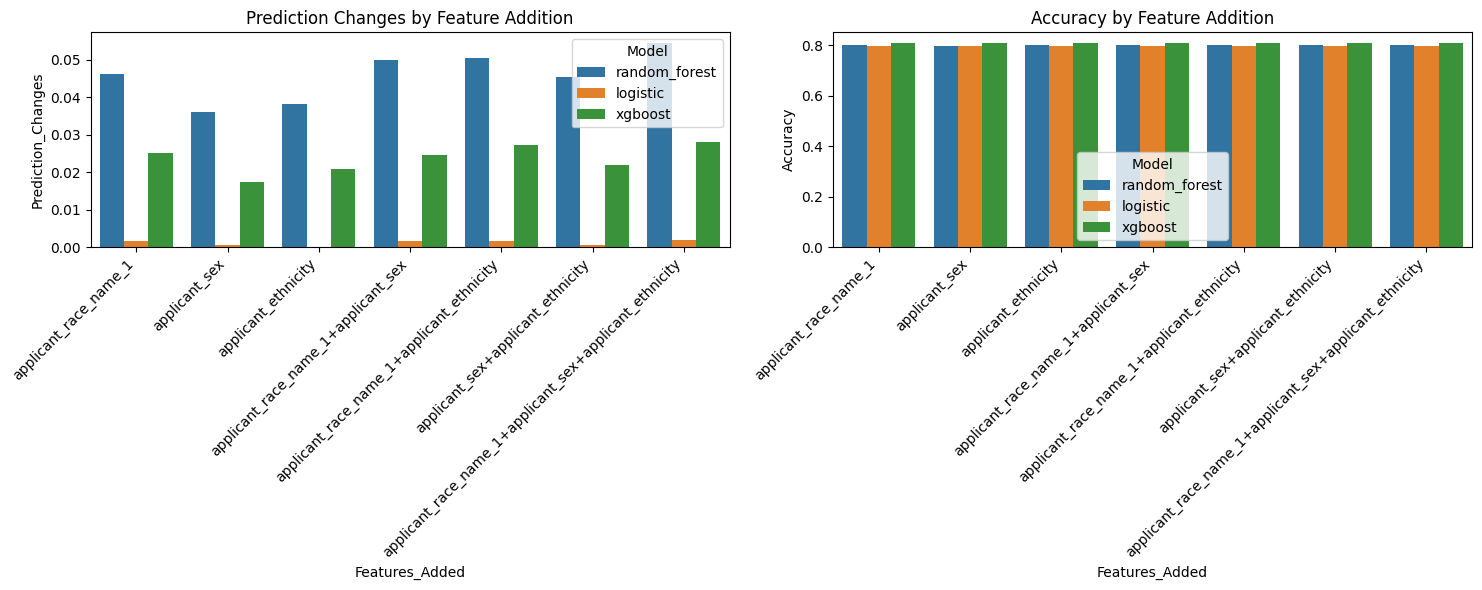


Detailed Results:
            Model                                           Features_Added  Prediction_Changes  Accuracy
0   random_forest                                    applicant_race_name_1            0.046223  0.799868
1        logistic                                    applicant_race_name_1            0.001493  0.797965
2         xgboost                                    applicant_race_name_1            0.025081  0.810132
3   random_forest                                            applicant_sex            0.035930  0.798331
4        logistic                                            applicant_sex            0.000439  0.797584
5         xgboost                                            applicant_sex            0.017467  0.808668
6   random_forest                                      applicant_ethnicity            0.038111  0.799927
7        logistic                                      applicant_ethnicity            0.000073  0.797570
8         xgboost                   

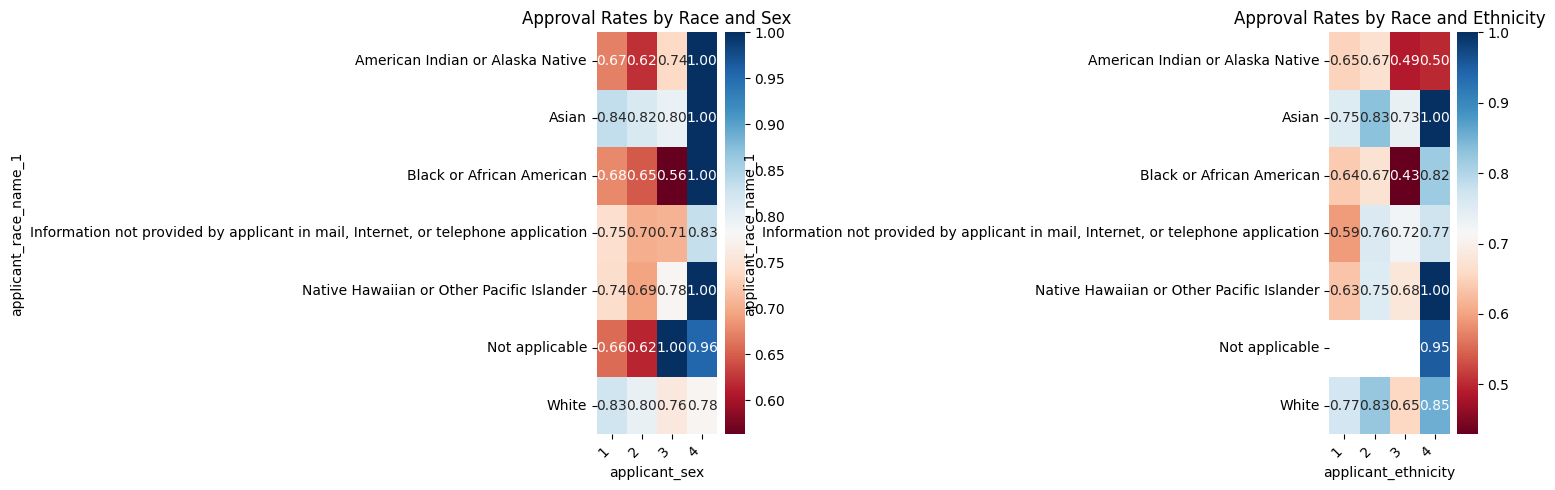


Intersectional Approval Rates (Race and Sex):
applicant_sex                                           1      2      3      4
applicant_race_name_1                                                         
American Indian or Alaska Native                    0.672  0.622  0.738  1.000
Asian                                               0.835  0.817  0.796  1.000
Black or African American                           0.677  0.648  0.563  1.000
Information not provided by applicant in mail, ...  0.745  0.702  0.705  0.833
Native Hawaiian or Other Pacific Islander           0.744  0.694  0.778  1.000
Not applicable                                      0.657  0.615  1.000  0.955
White                                               0.825  0.797  0.759  0.778

Intersectional Approval Rates (Race and Ethnicity):
applicant_ethnicity                                     1      2      3      4
applicant_race_name_1                                                         
American Indian or Alaska Nativ

In [7]:
# part 5

def encode_categorical_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Encode categorical features for model input.
    """
    X_encoded = X.copy()
    le = LabelEncoder()
    
    # Encode categorical columns
    for column in X.columns:
        if X[column].dtype == 'object':
            X_encoded[column] = le.fit_transform(X[column])
    
    return X_encoded

def analyze_sequential_feature_addition(data: pd.DataFrame, models: Dict, scalers: Dict, feature_groups: Dict) -> None:
    """
    Analyze how adding each sensitive feature sequentially affects model predictions.
    """
    print("\nAnalyzing sequential feature addition...")
    
    sensitive_features = ['applicant_race_name_1', 'applicant_sex', 'applicant_ethnicity']
    feature_combinations = []
    
    # Create all combinations of sensitive features
    for i in range(len(sensitive_features)):
        for combo in itertools.combinations(sensitive_features, i+1):
            feature_combinations.append(list(combo))
    
    results = []
    baseline_predictions = {}
    
    # Get baseline predictions for each model
    for model_name, model_info in models['baseline'].items():
        baseline_predictions[model_name] = model_info['predictions']
    
    # Train models with different feature combinations
    for features in feature_combinations:
        feature_set = feature_groups['baseline'] + features
        X = data[feature_set]
        X_encoded = encode_categorical_features(X)
        y = data['approved']
        
        X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        for model_name, model_info in models['baseline'].items():
            model = model_info['model']
            model.fit(X_train_scaled, y_train)
            new_predictions = model.predict(X_test_scaled)
            
            # Calculate changes from baseline
            changes = (new_predictions != baseline_predictions[model_name]).mean()
            
            results.append({
                'Model': model_name,
                'Features_Added': '+'.join(features),
                'Prediction_Changes': changes,
                'Accuracy': accuracy_score(y_test, new_predictions)
            })
    
    # Create visualization
    plt.figure(figsize=(15, 6))
    
    # Plot prediction changes
    plt.subplot(1, 2, 1)
    df_results = pd.DataFrame(results)
    sns.barplot(data=df_results, 
                x='Features_Added', y='Prediction_Changes', 
                hue='Model')
    plt.title('Prediction Changes by Feature Addition')
    plt.xticks(rotation=45, ha='right')
    
    # Plot accuracy changes
    plt.subplot(1, 2, 2)
    sns.barplot(data=df_results, 
                x='Features_Added', y='Accuracy', 
                hue='Model')
    plt.title('Accuracy by Feature Addition')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\nDetailed Results:")
    print(df_results.to_string())

def analyze_intersectional_bias(data: pd.DataFrame) -> None:
    """
    Analyze intersectional bias between different demographic features.
    """
    print("\nAnalyzing intersectional bias...")
    
    plt.figure(figsize=(15, 5))
    
    # Race and Sex intersection
    plt.subplot(1, 2, 1)
    intersection_rates = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='applicant_sex',
        aggfunc='mean'
    )
    sns.heatmap(intersection_rates, annot=True, fmt='.2f', cmap='RdBu')
    plt.title('Approval Rates by Race and Sex')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Race and Ethnicity intersection
    plt.subplot(1, 2, 2)
    intersection_rates_eth = pd.pivot_table(
        data=data,
        values='approved',
        index='applicant_race_name_1',
        columns='applicant_ethnicity',
        aggfunc='mean'
    )
    sns.heatmap(intersection_rates_eth, annot=True, fmt='.2f', cmap='RdBu')
    plt.title('Approval Rates by Race and Ethnicity')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    print("\nIntersectional Approval Rates (Race and Sex):")
    print(intersection_rates.round(3))
    print("\nIntersectional Approval Rates (Race and Ethnicity):")
    print(intersection_rates_eth.round(3))

if __name__ == "__main__":
    # Run sequential feature analysis
    analyze_sequential_feature_addition(data, models, scalers, feature_groups)
    
    # Run intersectional bias analysis
    analyze_intersectional_bias(data)


Comparing ML models with historical decisions...


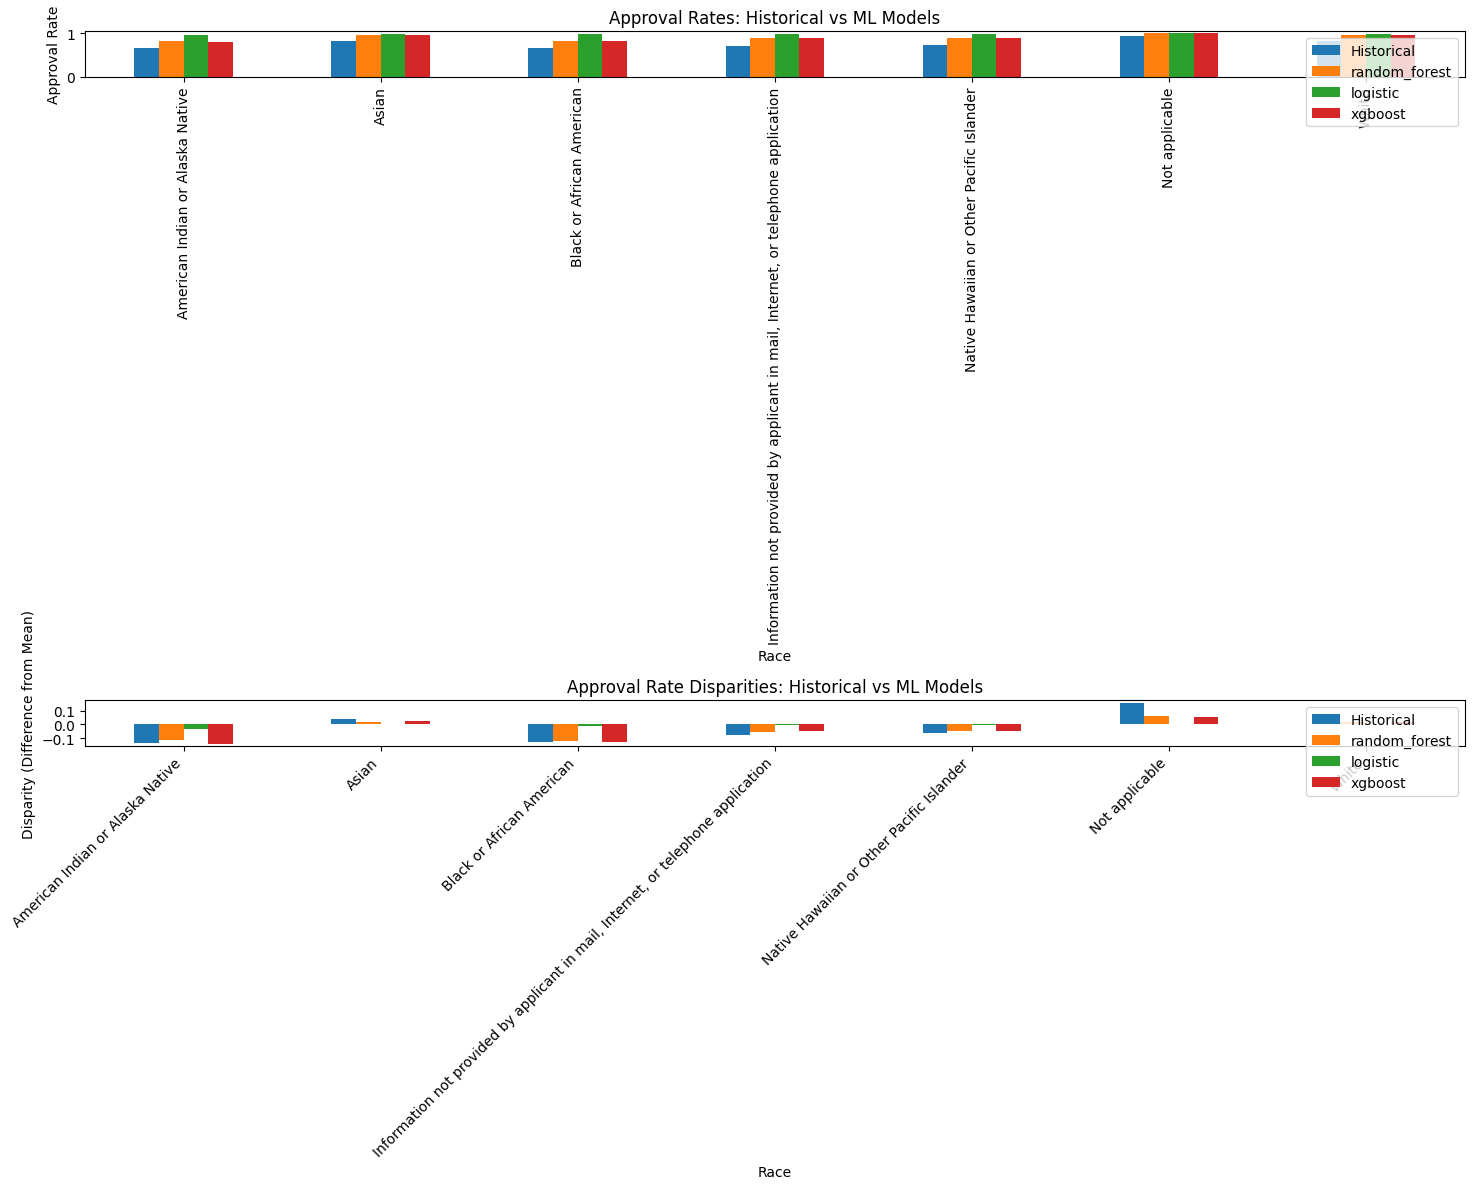


Detailed Approval Rates:
                                                    Historical  random_forest  \
applicant_race_name_1                                                           
American Indian or Alaska Native                         0.655          0.825   
Asian                                                    0.829          0.958   
Black or African American                                0.664          0.816   
Information not provided by applicant in mail, ...       0.716          0.885   
Native Hawaiian or Other Pacific Islander                0.729          0.889   
Not applicable                                           0.953          1.000   
White                                                    0.816          0.959   

                                                    logistic  xgboost  
applicant_race_name_1                                                  
American Indian or Alaska Native                       0.961    0.803  
Asian                       

In [8]:
# part 6

def compare_human_ml_bias(data: pd.DataFrame, models: Dict, datasets: Dict) -> None:
    """
    Compare ML model biases with historical human decisions.
    """
    print("\nComparing ML models with historical decisions...")
    
    # Get test set indices and data
    _, test_data, _, y_test = datasets['all_features']
    test_indices = test_data.index
    test_demographics = data.loc[test_indices]
    
    # Calculate historical approval rates by race
    historical_rates = data.groupby('applicant_race_name_1')['approved'].mean()
    
    # Calculate ML model approval rates by race
    ml_rates = {}
    for model_name, model_info in models['all_features'].items():
        predictions = model_info['predictions']
        ml_rates[model_name] = (
            pd.DataFrame({'race': test_demographics['applicant_race_name_1'], 
                         'approved': predictions})
            .groupby('race')['approved']
            .mean()
        )
    
    # Combine all rates into one DataFrame
    comparison_df = pd.DataFrame({'Historical': historical_rates})
    for model_name, rates in ml_rates.items():
        comparison_df[model_name] = rates
    
    # Calculate disparities (difference from overall mean)
    overall_historical = data['approved'].mean()
    overall_ml = {model: pred['predictions'].mean() 
                 for model, pred in models['all_features'].items()}
    
    disparity_df = pd.DataFrame({'Historical': comparison_df['Historical'] - overall_historical})
    for model in ml_rates.keys():
        disparity_df[model] = comparison_df[model] - overall_ml[model]
    
    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Plot 1: Approval Rates Comparison
    comparison_df.plot(kind='bar', ax=ax1)
    ax1.set_title('Approval Rates: Historical vs ML Models')
    ax1.set_xlabel('Race')
    ax1.set_ylabel('Approval Rate')
    plt.xticks(rotation=45, ha='right')
    
    # Plot 2: Disparity Comparison
    disparity_df.plot(kind='bar', ax=ax2)
    ax2.set_title('Approval Rate Disparities: Historical vs ML Models')
    ax2.set_xlabel('Race')
    ax2.set_ylabel('Disparity (Difference from Mean)')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nDetailed Approval Rates:")
    print(comparison_df.round(3))
    print("\nDetailed Disparities:")
    print(disparity_df.round(3))
    
    # Calculate bias amplification/reduction
    print("\nBias Amplification Analysis:")
    for model in ml_rates.keys():
        amplification = (disparity_df[model].abs() / disparity_df['Historical'].abs()).mean()
        print(f"{model} bias amplification factor: {amplification:.3f}")
        # >1 means model amplifies historical bias, <1 means it reduces it

if __name__ == "__main__":
    # Run historical comparison
    compare_human_ml_bias(data, models, datasets)